In [9]:
import os

# Manually set the __file__ variable to the notebook's directory
__file__ = os.path.abspath("notebook_name.ipynb")


In [10]:
import os
import json
import re
from typing import List, Union, Optional
from typing_extensions import TypedDict

# LangChain / LangGraph
from langchain_core.messages import (
    AIMessage, 
    HumanMessage,
    SystemMessage,
    BaseMessage
)
from langchain_openai import ChatOpenAI
from langgraph.constants import START, END
from langgraph.graph import StateGraph, MessagesState

# Example: your custom ChatGroq usage
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature=0,
    model_name="llama-3.3-70b-specdec",
    api_key="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"
)
# llm = ChatOpenAI(model="gpt-4o",
#         temperature=0)

def load_xml_instructions(filename: str) -> str:
    """
    Load system instructions from 'XML_instructions/filename' if you keep them externally.
    Otherwise, just inline your prompts as strings.
    """
    current_dir = os.path.dirname(os.path.abspath(__file__))
    file_path = os.path.join(current_dir, "XML_instructions", filename)
    with open(file_path, "r", encoding="utf-8") as f:
        return f.read()

class FinalReportState(TypedDict):
    """
    Our final JSON structures and clarity status.
    """
    instructions_clear: bool
    layout_json: dict
    final_json: dict

class ReportGraphState(MessagesState, FinalReportState):
    """
    Merges the base conversation messages plus our custom fields.
    'messages' is a list of SystemMessage, HumanMessage, or AIMessage.
    """
    pass
from pydantic import BaseModel, Field

class Components(BaseModel):
    Components: list[str]

class NestedNumberFormat(BaseModel):
    scale: str
    decimals: int

# Define the lowest-level models first
class GridColumns(BaseModel):
    sm: Union[int, str]
    md: Union[int, str]
    lg: Union[int, str]

    class Config:
        extra = "forbid"

class ColSpan(BaseModel):
    sm: Union[int, str]
    md: Union[int, str]
    lg: Union[int, str]

    class Config:
        extra = "forbid"

class NestedNumberFormat(BaseModel):
    scale: str
    decimals: int

    class Config:
        extra = "forbid"

# Define rows and columns next
class Component(BaseModel):
    id: str
    type: str
    title: Optional[str] = None
    AI_Generation_Description: Optional[str] = Field(
        None,
        alias="AI Generation Description"
    )
    noborder: Optional[bool] = None
    height: Optional[int] = None
    numberFormat: Optional[NestedNumberFormat] = None
    config: Optional["Layout"] = None  # Use forward reference for recursive Layout

    class Config:
        populate_by_name = True
        extra = "forbid"

class Column(BaseModel):
    colSpan: ColSpan
    components: List[Component]

    class Config:
        extra = "forbid"

class Row(BaseModel):
    columns: List[Column]

    class Config:
        extra = "forbid"

# Define layout after rows and columns
class Layout(BaseModel):
    gridColumns: Optional[GridColumns] = None
    rows: List[Row]

    class Config:
        extra = "forbid"

# Define the top-level models
class NumberFormat(BaseModel):
    currency: str
    scale: str
    decimals: int

    class Config:
        extra = "forbid"

class ReportConfig(BaseModel):
    reportTitle: str
    numberFormat: NumberFormat
    layout: Layout

    class Config:
        extra = "forbid"

from Nodes.helper_functions import *
# -----------------------------------------------------------------------------
# 4) generate_layout_json
# -----------------------------------------------------------------------------
def generate_layout_json(state: ReportGraphState):
    """
    We assume instructions are now clear. 
    Use 'render_layout.xml' as system instructions, plus the entire conversation.
    Then parse out a JSON layout from the LLM output.
    """
    system_instructions = load_xml_instructions("render_layout.xml")
    system_msg = SystemMessage(content=system_instructions)

    conversation = [system_msg] + state["messages"]
    
    from langchain_core.pydantic_v1 import BaseModel
    structured_llm = llm.with_structured_output(
        ReportConfig,
        method="json_mode",
        include_raw=True
    )

    output = structured_llm.invoke(conversation)
    parsed_output = output["parsed"]

    parsed_output = parsed_output.dict(exclude_none=True, by_alias=True)

    # Store the AI’s layout as a message for transparency
    state["layout_json"] =parsed_output

    
    return {"layout_json": remove_null_entries(parsed_output)}

# -----------------------------------------------------------------------------
# Build the Graph
# -----------------------------------------------------------------------------
builder = StateGraph(ReportGraphState)

builder.add_node("generate_layout_json", generate_layout_json)

builder.add_edge(START, "generate_layout_json")
builder.add_edge("generate_layout_json", END)

# Finally, compile without using interrupt_before, because we rely on conversation-based logic
graph = builder.compile()



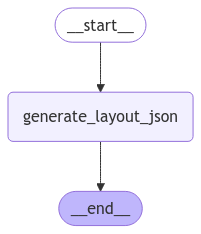

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
state = ReportGraphState(
    messages=[
        HumanMessage(content="Create a report showing the profit and loss in a table comparing actuals to budget. Next to the table I want to see a chart with 12 periods comparing Actuals to Budget for the current selected row in the table. Below the chart I want to see a small table breaking down the current selected line in to the product dimension.", name="user")
    ],
    instructions_clear=False,
    layout_json={},
    final_json={}
)

# Invoke the graph
result_state = graph.invoke(state)

# Extract and display clean JSON
parsed_result = result_state['layout_json']
print(parsed_result)
# parsed_result = remove_null_entries(parsed_result)
# if parsed_result:
#     # Convert parsed result to dictionary and then to JSON string for clean display
#     clean_json = json.dumps(parsed_result.dict(by_alias=True), indent=2)
#     from IPython.display import Markdown
#     display(Markdown(f"```json\n{clean_json}\n```"))
# else:
#     print("No parsed result found.")


{'reportTitle': 'Profit and Loss - Analysis', 'numberFormat': {'currency': 'USD', 'scale': 'thousands', 'decimals': 0}, 'layout': {'gridColumns': {'sm': 1, 'md': 1, 'lg': 8}, 'rows': [{'columns': [{'colSpan': {'sm': 1, 'md': 1, 'lg': 5}, 'components': [{'id': 'C1', 'type': 'ReportTable', 'AI Generation Description': 'A table showing the profit and loss statement on the rows and comparing actuals to budget with a variance bar on the columns. The rows should be selectable.'}]}, {'colSpan': {'sm': 1, 'md': 1, 'lg': 3}, 'components': [{'id': 'N1', 'type': 'NestedRow', 'config': {'rows': [{'columns': [{'colSpan': {'sm': 1, 'md': 1, 'lg': 3}, 'components': [{'id': 'C2', 'type': 'Chart', 'title': 'Actuals to Budget - [Account]', 'AI Generation Description': 'A column chart with 12 periods comparing Actuals to Budget.', 'height': 300}]}]}, {'columns': [{'colSpan': {'sm': 1, 'md': 1, 'lg': 3}, 'components': [{'id': 'C3', 'type': 'ReportTable', 'title': 'Fund Drilldown for [Account]', 'AI Genera

C:\Users\woute\AppData\Local\Temp\ipykernel_31116\2400157238.py:166: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  parsed_output = parsed_output.dict(exclude_none=True, by_alias=True)


: 